In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import uproot
import histlite as hl
import scipy.interpolate as interp
from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (10,8)

/cvmfs/lz.opensciencegrid.org/external/Python/3.8.2/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
replayed_data_dir = '/global/cfs/cdirs/lux/users/haselsco/TUNL_August_2021_Data/replayed/slurm_run30235/'

replay_period = 12800. # ns, period used in replay processing of the data
escale_pmt = 0.6219 # keV/PH, from Ba-133 cal fit
escale_sipm = 0.1868 # keV/PH, from Ba-133 cal fit

rootfiles = [filename for filename in os.listdir(replayed_data_dir) if filename.endswith('.root')]
n_open = 1
for i,thisfile in enumerate(rootfiles[:n_open]):
    if i % 10 == 0:
        print('Opening {} of {}'.format(i,len(rootfiles)))
    fullpath = replayed_data_dir + thisfile
    
    data_list_gamma = []
    data_list_ndet = []
        
    data_list_gamma.append( uproot.open(fullpath)['gamma_events'].arrays( ["*"], outputtype=pd.DataFrame ) )
    data_list_ndet.append( uproot.open(fullpath)['ndet_events'].arrays( ["*"], outputtype=pd.DataFrame ) )
    gdata = pd.concat(data_list_gamma,ignore_index=True)
    ndata = pd.concat(data_list_ndet,ignore_index=True)

Opening 0 of 223


In [9]:
ndata.head()

,ndet_ch,ndet_PH,ndet_E,ndet_ts,ndet_tof,ndet_PSD,ndet_PSD_cut,ndet_flash,ndet_true_time
0,18.0,2683.0,0.0,6.784935e+11,10854.649931,4.813105,9.50,2436.0,8418.649931
1,7.0,16383.0,0.0,6.785231e+11,2697.003942,6.233589,8.50,2452.0,245.003942
2,19.0,4458.0,0.0,6.785350e+11,12101.729161,4.034536,9.00,2448.0,9653.729161
3,17.0,989.0,0.0,6.785662e+11,7967.966027,9.521426,10.50,2450.0,5517.966027
4,8.0,1401.0,0.0,6.785663e+11,8856.263189,5.174386,7.25,2483.0,6373.263189


In [27]:
#ndf_cp = pd.DataFrame(columns=ndata.columns, index=ndata.index).dropna(axis=0,how='any')

# create the columns in the ndet data frame we want to fill

ndf_cp = ndata.copy()
ndf_cp['delta_t'] = ""
ndf_cp['gamma_ch'] = ""
ndf_cp['gamma_PH'] = ""
ndf_cp['gamma_ts'] = ""
ndf_cp['gamma_t10'] = ""
ndf_cp['gamma_t25'] = ""
ndf_cp['gamma_t50'] = ""
ndf_cp['gamma_t90'] = ""

ndf_cp.head()

,ndet_ch,ndet_PH,ndet_E,ndet_ts,ndet_tof,ndet_PSD,ndet_PSD_cut,ndet_flash,ndet_true_time,delta_t,gamma_ch,gamma_PH,gamma_ts,gamma_t10,gamma_t25,gamma_t50,gamma_t90
0,18.0,2683.0,0.0,6.784935e+11,10854.649931,4.813105,9.50,2436.0,8418.649931,,,,,,,,
1,7.0,16383.0,0.0,6.785231e+11,2697.003942,6.233589,8.50,2452.0,245.003942,,,,,,,,
2,19.0,4458.0,0.0,6.785350e+11,12101.729161,4.034536,9.00,2448.0,9653.729161,,,,,,,,
3,17.0,989.0,0.0,6.785662e+11,7967.966027,9.521426,10.50,2450.0,5517.966027,,,,,,,,
4,8.0,1401.0,0.0,6.785663e+11,8856.263189,5.174386,7.25,2483.0,6373.263189,,,,,,,,


In [28]:
window = 10000. #ns
gvar_names = [ 'gamma_ch', 'gamma_PH', 'gamma_ts', 'gamma_t10', 'gamma_t25', 'gamma_t50', 'gamma_t90' ]
for idx, row in ndf_cp.iterrows():
    #print( row['ndet_ts'] )
    
    coinc = gdata.loc[ np.abs(row['ndet_ts'] - gdata['gamma_ts'])<window ] # selects only gamma pulses within window around ndet pulse
    
    # fill in coincident gamma pulse info:
    ndf_cp.at[idx,'delta_t'] = (row['ndet_ts'] - coinc['gamma_ts']).tolist()
    for name in gvar_names:
        ndf_cp.at[idx,name] = coinc[name].tolist()

In [29]:
ndf_cp.head()

,ndet_ch,ndet_PH,ndet_E,ndet_ts,ndet_tof,ndet_PSD,ndet_PSD_cut,ndet_flash,ndet_true_time,delta_t,gamma_ch,gamma_PH,gamma_ts,gamma_t10,gamma_t25,gamma_t50,gamma_t90
0,18.0,2683.0,0.0,6.784935e+11,10854.649931,4.813105,9.50,2436.0,8418.649931,"[9051.12255859375, 7683.6116943359375, 5999.20...","[30.0, 27.0, 30.0, 27.0, 30.0, 27.0, 30.0, 27....","[1144.916666666664, 169.51666666666478, 1108.8...","[678493494987.973, 678493496355.4839, 67849349...","[137.0, 92.0, 94.0, 289.0, 118.0, 82.0, 100.0,...","[239.0, 135.0, 114.0, 348.0, 209.0, 112.0, 140...","[412.0, 179.0, 153.0, 406.0, 302.0, 408.0, 260...","[476.0, 282.0, 466.0, 472.0, 455.0, 479.0, 431..."
1,7.0,16383.0,0.0,6.785231e+11,2697.003942,6.233589,8.50,2452.0,245.003942,"[625.85791015625, 277.0421142578125, -2218.421...","[27.0, 30.0, 30.0, 27.0, 30.0, 27.0, 30.0, 27....","[164.48333333333264, 774.5083333333309, 1137.7...","[678523108425.9535, 678523108774.7693, 6785231...","[100.0, 120.0, 109.0, 92.0, 200.0, 88.0, 115.0...","[145.0, 197.0, 252.0, 141.0, 232.0, 136.0, 179...","[404.0, 255.0, 296.0, 296.0, 305.0, 296.0, 366...","[468.0, 312.0, 475.0, 424.0, 474.0, 465.0, 468..."
2,19.0,4458.0,0.0,6.785350e+11,12101.729161,4.034536,9.00,2448.0,9653.729161,"[1053.6429443359375, 927.8345947265625, -1488....","[27.0, 30.0, 27.0, 30.0, 27.0, 30.0, 27.0, 30.0]","[675.7500000000002, 750.0416666666626, 24.0250...","[678534957569.6842, 678534957695.4926, 6785349...","[98.0, 96.0, 10.0, 3.0, 78.0, 275.0, 84.0, 302.0]","[253.0, 132.0, 69.0, 9.0, 108.0, 301.0, 93.0, ...","[409.0, 210.0, 75.0, 18.0, 317.0, 325.0, 129.0...","[472.0, 286.0, 98.0, 80.0, 480.0, 436.0, 445.0..."
3,17.0,989.0,0.0,6.785662e+11,7967.966027,9.521426,10.50,2450.0,5517.966027,"[559.6021728515625, 446.5301513671875, -2138.2...","[27.0, 30.0, 30.0, 27.0, 30.0, 27.0, 30.0, 27.0]","[4.474999999999716, 1734.8500000000001, 196.10...","[678566211931.8511, 678566212044.9231, 6785662...","[0.0, 169.0, 8.0, 2.0, 118.0, 119.0, 256.0, 24.0]","[0.0, 237.0, 81.0, 110.0, 239.0, 331.0, 274.0,...","[2.0, 330.0, 143.0, 174.0, 369.0, 353.0, 304.0...","[13.0, 475.0, 173.0, 178.0, 459.0, 429.0, 483...."
4,8.0,1401.0,0.0,6.785663e+11,8856.263189,5.174386,7.25,2483.0,6373.263189,"[1095.709716796875, 752.8807373046875, -1636.8...","[30.0, 27.0, 30.0, 27.0, 30.0, 27.0, 30.0, 27.0]","[967.8083333333382, 695.1166666666569, 500.916...","[678566314684.0377, 678566315026.8667, 6785663...","[142.0, 75.0, 114.0, 99.0, 148.0, 157.0, 187.0...","[230.0, 92.0, 154.0, 249.0, 215.0, 392.0, 241....","[271.0, 131.0, 216.0, 299.0, 309.0, 440.0, 328...","[436.0, 267.0, 372.0, 374.0, 362.0, 484.0, 453..."


In [38]:
def flatten(t):
    return [item for sublist in t for item in sublist]

deltas = flatten( ndf_cp['delta_t'].tolist() )

NameError: name 'Expon' is not defined

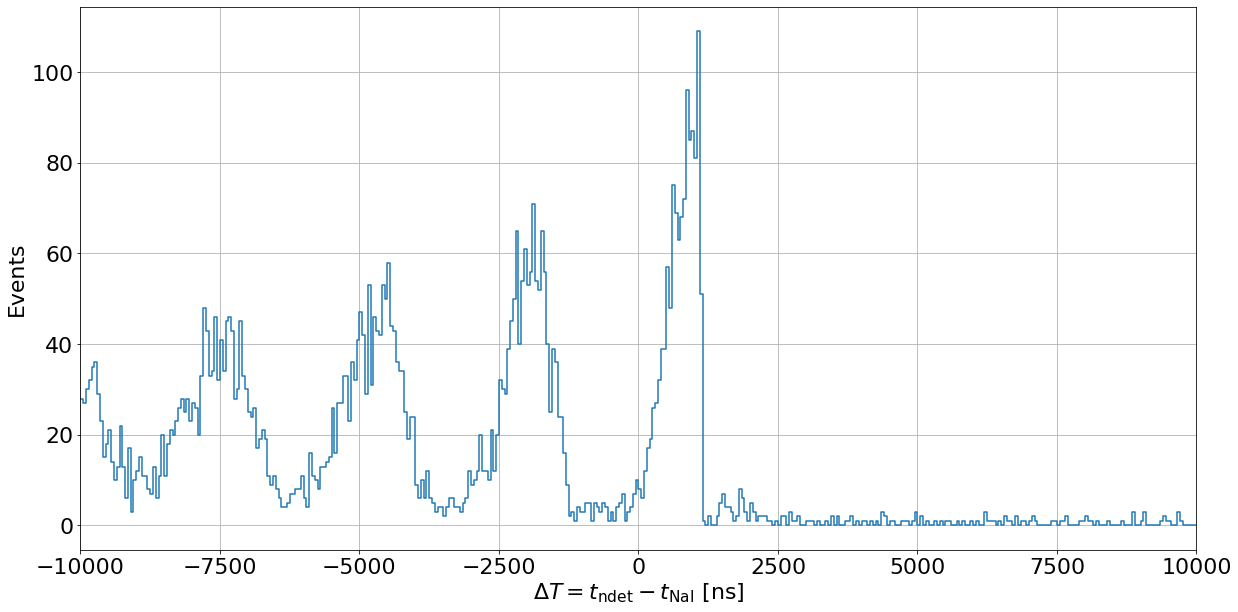

In [39]:
# plot time diffs
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
r=(-window,window)
h_dt = hl.hist( deltas , bins=400, range=r)
hl.plot1d(h_dt)
#plt.yscale('log')
plt.xlabel(r'$\Delta T = t_{\rm ndet} - t_{\rm NaI}$ [ns]')
plt.ylabel('Events')
plt.xlim(-window,window)
#plt.xticks(np.arange(-window, window+1000, step=1000))
plt.grid()


bincenters = (h_dt.bins[0][1:] + h_dt.bins[0][:-1])/2.
binvals = h_dt.values

fitmin = -400.
fitmax = 600.

fitmask = (bincenters > fitmin) & (bincenters <fitmax)
p, cov = curve_fit( Expon, bincenters[fitmask], binvals[fitmask], p0=(5.,fitmin,-300.))
xfit = np.linspace(fitmin,fitmax,500)
plt.plot(xfit,Expon( xfit, *p),'-r', linewidth=3, label=r'$\tau = {:0.1f}$ ns'.format(p[2]))

plt.legend(fontsize=28)


In [3]:

n_open = 1

glob_nts = []
glob_gts = []
glob_dts = [] # difference in time stamps between ndet and NaI - all NaI in coinc window
glob_dts_short = [] # difference in time stamps between ndet and NaI - closest NaI pulse in time only
glob_dtn = [] # difference in time stamps between ndet events

glob_gPH = [] # coincidence gamma event pulse heights
glob_gt10 = [] # coincidence gamma
glob_gt25 = [] # coincidence gamma
glob_gt50 = [] # coincidence gamma
glob_gt90 = [] # coincidence gamma

print('{} files found.'.format(len(rootfiles)))
print('only opening {} of these...'.format(n_open))

ndet_chan = 21

for i,thisfile in enumerate(rootfiles[:n_open]):
    if i % 10 == 0:
        print('Opening {} of {}'.format(i,len(rootfiles)))
    fullpath = replayed_data_dir + thisfile
    
    data_list_gamma = []
    data_list_ndet = []
        
    data_list_gamma.append( uproot.open(fullpath)['gamma_events'].arrays( ["*"], outputtype=pd.DataFrame ) )
    data_list_ndet.append( uproot.open(fullpath)['ndet_events'].arrays( ["*"], outputtype=pd.DataFrame ) )
    gdata = pd.concat(data_list_gamma,ignore_index=True)
    ndata = pd.concat(data_list_ndet,ignore_index=True)
    
    ######
    #n_mask = (ndata['ndet_PH'] < 15000) & (ndata['ndet_ch'] == ndet_chan) # & (ndata['ndet_PH'] > 6500)
    n_mask = (ndata['ndet_PH'] < 15000) & (ndata['ndet_PH'] > 6500)
    clean_ndata = ndata.loc[n_mask]
    
    #g_mask = (gdata['gamma_ch'] == 27) | (gdata['gamma_ch'] == 30)
    g_mask = (gdata['gamma_ch'] == 27)
    clean_gdata = gdata.loc[g_mask]
    
    #pmt_mask = (gdata['gamma_ch'] == 27)
    #sipm_mask = (gdata['gamma_ch'] == 30)
    #clean_pmt_data = gdata.loc[pmt_mask]
    #clean_sipm_data = gdata.loc[sipm_mask]
    
    ########
    
    print( 'there are {} neutron evts'.format( clean_ndata.shape[0] ) )
    print( 'there are {} gamma evts'.format( clean_gdata.shape[0] ) )

    num_nts = clean_ndata['ndet_ts'].shape[0]
    num_gts = clean_gdata['gamma_ts'].shape[0]
    #print( 'there are {} n TS\'s'.format( num_nts ) )
    #print( 'there are {} g TS\'s'.format( num_gts ) )

    prev_nts = 0.
    for i,nts in enumerate(clean_ndata['ndet_ts']):
        if i % 100 == 0:
            print('on TS number {}'.format(i))
        
        gamma_ts = clean_gdata['gamma_ts'].to_numpy()
        gamma_PH = clean_gdata['gamma_PH'].to_numpy()
        gamma_t10 = clean_gdata['gamma_t10'].to_numpy()
        gamma_t25 = clean_gdata['gamma_t25'].to_numpy()
        gamma_t50 = clean_gdata['gamma_t50'].to_numpy()
        gamma_t90 = clean_gdata['gamma_t90'].to_numpy()
        # search sorted method:
        #ts_idx = gamma_ts.searchsorted( nts )
        #if ts_idx<len(gamma_ts):
        #    gts = gamma_ts[ts_idx]
        #else:
        #    continue
        
        # absolute shortest time method:
        #gts = gamma_ts[np.abs(gamma_ts - nts).argmin()]
        
        # all within some window
        window = 10000. #ns
        diff = nts - gamma_ts
        coinc_ts = diff[np.abs(diff)<window]
        coinc_PH = gamma_PH[np.abs(diff)<window]
        coinc_t10 = gamma_t10[np.abs(diff)<window]
        coinc_t25 = gamma_t25[np.abs(diff)<window]
        coinc_t50 = gamma_t50[np.abs(diff)<window]
        coinc_t90 = gamma_t90[np.abs(diff)<window]
        #print(coinc)
        
        #print('delta TS = {}'.format(nts-gts))
        #print('{} sec have passed since last ndet evt'.format((nts-prev_nts)*1e-9))
        #print('index is {}'.format(ts_idx))
        #print('ndet TS is {}'.format(nts))
        #print('PMT TS is {}\n'.format(gts))
        #glob_gts.append(gts)
        #glob_dts_short.append( nts-gts )
        #glob_dts.append(nts-gts)
        
        glob_nts.append(nts)
        glob_dts.append( coinc_ts.tolist() )
        glob_gPH.append( coinc_PH.tolist() )
        glob_gt10.append( coinc_t10.tolist() )
        glob_gt25.append( coinc_t25.tolist() )
        glob_gt50.append( coinc_t50.tolist() )
        glob_gt90.append( coinc_t90.tolist() )
        
        if i!=0:
            glob_dtn.append( nts - prev_nts )
        
        prev_nts = nts
    


223 files found.
only opening 200 of these...
Opening 0 of 223
there are 23 neutron evts
there are 136632 gamma evts
on TS number 0
there are 39 neutron evts
there are 136604 gamma evts
on TS number 0
there are 17 neutron evts
there are 136690 gamma evts
on TS number 0
there are 21 neutron evts
there are 136601 gamma evts
on TS number 0
there are 23 neutron evts
there are 136763 gamma evts
on TS number 0
there are 25 neutron evts
there are 136729 gamma evts
on TS number 0
there are 34 neutron evts
there are 136695 gamma evts
on TS number 0
there are 25 neutron evts
there are 136831 gamma evts
on TS number 0
there are 28 neutron evts
there are 136767 gamma evts
on TS number 0
there are 17 neutron evts
there are 136497 gamma evts
on TS number 0
Opening 10 of 223
there are 28 neutron evts
there are 136844 gamma evts
on TS number 0
there are 23 neutron evts
there are 136767 gamma evts
on TS number 0
there are 42 neutron evts
there are 136477 gamma evts
on TS number 0
there are 25 neutron e